In [1]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install transformers

In [3]:
!pip install tensorflow_addons

In [4]:
import os
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
MODEL_NAME = "klue/bert-base"
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5, from_pt=True)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  print("GPU 작동 중")
  mirrored_strategy = tf.distribute.MirroredStrategy()
else:
  print("GPU 미작동 중")

GPU 작동 중


In [7]:
dataset = pd.read_csv('/content/drive/MyDrive/에이블스쿨_미니프로젝트/Mini_Project4_2/2023.10.16_미니프로젝트4차_실습자료/pre_data.csv')
dataset.head()

,text,label
0,self convs1 nn ModuleList nn Conv2d 1 Co K 100...,0
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,1
2,glob glob PATH 를 사용할 때 질문입니다 PATH에 가 포함되면 제대로 ...,0
3,tmpp tmp groupby by Addr1 as index False Categ...,0
4,filename TEST IMAGE str round frame sec jpg 이렇...,0


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3706 entries, 0 to 3705
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3706 non-null   object
 1   label   3706 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 58.0+ KB


In [9]:
# 중복 데이터 확인
dataset[dataset['text'].duplicated()]

,text,label


Text(0, 0.5, 'Number')

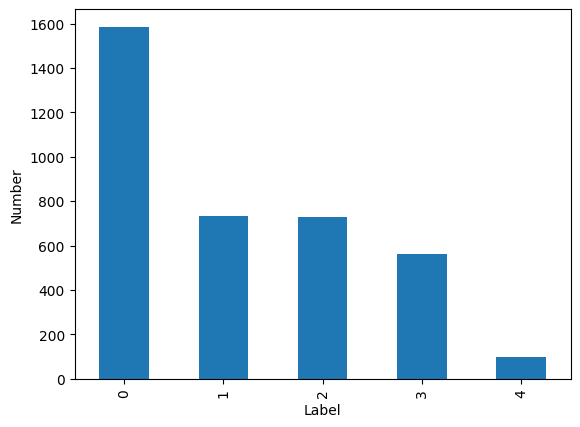

In [10]:
dataset['label'].value_counts().plot(kind = 'bar')
plt.xlabel("Label")
plt.ylabel("Number")

In [11]:
dataset['label'].value_counts(normalize = True)

0    0.427685
1    0.197518
2    0.196438
3    0.151376
4    0.026983
Name: label, dtype: float64

In [12]:
# 입출력 데이터 분리
X_data = dataset['text']
y_data = dataset['label']

In [13]:
TEST_SIZE = 0.2 # Train: Test = 8 :2 분리
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE,
                                                    stratify = y_data)

In [14]:
print(f"훈련 입력 데이터 개수: {len(X_train)}")
print(f"테스트 입력 데이터 개수: {len(X_test)}")

훈련 입력 데이터 개수: 2964
테스트 입력 데이터 개수: 742


In [15]:
# 훈련 데이터 라벨별 비율
y_train.value_counts(normalize = True)

0    0.427800
1    0.197368
2    0.196356
3    0.151484
4    0.026991
Name: label, dtype: float64

In [16]:
# 테스트 데이터 라벨별 비율
y_test.value_counts(normalize = True)

0    0.427224
1    0.198113
2    0.196765
3    0.150943
4    0.026954
Name: label, dtype: float64

In [17]:
# 입력 데이터(문장) 길이 제한
MAX_SEQ_LEN = 200

In [18]:
def convert_data(X_data, y_data):
    # BERT 입력으로 들어가는 token, mask, segment, target 저장용 리스트
    tokens, masks, segments, targets = [], [], [], []

    for X, y in tqdm(zip(X_data, y_data)):
        # token: 입력 문장 토큰화
        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)

        # Mask: 토큰화한 문장 내 패딩이 아닌 경우 1, 패딩인 경우 0으로 초기화
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros

        # segment: 문장 전후관계 구분: 오직 한 문장이므로 모두 0으로 초기화
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        targets.append(y)

    # numpy array로 저장
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

In [19]:
# train 데이터를 Bert의 Input 타입에 맞게 변환
train_x, train_y = convert_data(X_train, y_train)

2964it [00:02, 1349.49it/s]


In [20]:
# test 데이터를 Bert의 Input 타입에 맞게 변환
test_x, test_y = convert_data(X_test, y_test)

742it [00:00, 1399.22it/s]


In [21]:
# token, mask, segment 입력 정의
token_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_word_ids')
mask_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_masks')
segment_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_segment')
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

In [22]:
bert_output = bert_outputs[0]

In [23]:
DROPOUT_RATE = 0.5
NUM_CLASS = 5
dropout = tf.keras.layers.Dropout(DROPOUT_RATE)(bert_output)
# Multi-class classification 문제이므로 activation function은 softmax로 설정
sentiment_layer = tf.keras.layers.Dense(NUM_CLASS, activation='softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02))(dropout)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_layer)

In [32]:
# 옵티마이저 Rectified Adam 하이퍼파리미터 조정
OPTIMIZER_NAME = 'RAdam'
LEARNING_RATE = 0.0001
TOTAL_STEPS = 10000
MIN_LR = 1e-5
WARMUP_PROPORTION = 0.1
EPSILON = 1e-8
CLIPNORM = 1.0
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = LEARNING_RATE,
                                          total_steps = TOTAL_STEPS,
                                          warmup_proportion = WARMUP_PROPORTION,
                                          min_lr = MIN_LR,
                                          epsilon = EPSILON,
                                          clipnorm = CLIPNORM)

In [33]:
# 감정분류 모델 컴파일
sentiment_model.compile(optimizer = optimizer,
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics = ['accuracy'])

In [30]:
MIN_DELTA = 1e-3
PATIENCE = 10

early_stopping = EarlyStopping(
    monitor = "val_accuracy",
    min_delta = MIN_DELTA,
    patience = PATIENCE)

In [27]:
# 최고 성능의 모델 파일을 저장할 이름과 경로 설정
BEST_MODEL_NAME = './model/best_model.h5'
model_checkpoint = ModelCheckpoint(
    filepath = BEST_MODEL_NAME,
    monitor = "val_loss",
    mode = "min",
    save_best_only = True, # 성능 향상 시에만 모델 저장
    verbose = 1
)

In [28]:
callbacks = [early_stopping, model_checkpoint]

In [34]:
EPOCHS = 50
BATCH_SZIE = 8

sentiment_model.fit(train_x, train_y,
                    epochs = EPOCHS,
                    shuffle = True,
                    batch_size = BATCH_SZIE,
                    validation_data = (test_x, test_y),
                    callbacks = callbacks,
                    verbose=1
                    )

Epoch 1/50
371/371 [==============================] - ETA: 0s - loss: 0.6456 - accuracy: 0.7551
Epoch 1: val_loss did not improve from 0.66791
371/371 [==============================] - 187s 430ms/step - loss: 0.6456 - accuracy: 0.7551 - val_loss: 1.2615 - val_accuracy: 0.4003
Epoch 2/50
175/371 [=============>................] - ETA: 1:17 - loss: 1.5265 - accuracy: 0.3779

KeyboardInterrupt: ignored

In [50]:
# 최고 성능의 모델 불러오기
sentiment_model_best = tf.keras.models.load_model(BEST_MODEL_NAME,
                                                  custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})

In [51]:
# 모델이 예측한 라벨 도출
predicted_value = sentiment_model_best.predict(test_x)
predicted_label = np.argmax(predicted_value, axis = 1)

24/24 [==============================] - 18s 648ms/step


In [56]:
predicted_value

array([[0.87947756, 0.06970582, 0.02769759, 0.00883427, 0.01428477],
       [0.8794766 , 0.06970476, 0.02769903, 0.00883448, 0.01428511],
       [0.87947947, 0.06971184, 0.02769248, 0.00883301, 0.01428322],
       ...,
       [0.03264902, 0.03485113, 0.84880376, 0.01867451, 0.06502154],
       [0.8794742 , 0.06970832, 0.02770055, 0.00883269, 0.01428426],
       [0.0078891 , 0.01426082, 0.01935866, 0.85589933, 0.10259201]],
      dtype=float32)

In [52]:
cl_report = classification_report(test_y, predicted_label, output_dict = True)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(3)
print(cl_report_df)

              precision  recall  f1-score  support
0                 0.845   0.861     0.853  317.000
1                 0.862   0.721     0.785  147.000
2                 0.695   0.795     0.741  146.000
3                 0.873   0.857     0.865  112.000
4                 0.947   0.900     0.923   20.000
accuracy          0.821   0.821     0.821    0.821
macro avg         0.844   0.827     0.833  742.000
weighted avg      0.826   0.821     0.821  742.000


In [53]:
accuracy_score_v = round(accuracy_score(y_test, predicted_label), 3) # Accuracy
precision_score_v = round(precision_score(y_test, predicted_label, average="weighted"), 3) # Precision
recall_score_v = round(recall_score(y_test, predicted_label, average="weighted"), 3) # Recall
f1_score_v = round(f1_score(y_test, predicted_label, average="weighted"), 3) # F1 Score
roc_auc_score_v = round(roc_auc_score(y_test, predicted_value, average="weighted", multi_class="ovr"), 3) # ROC AUC Score
cohen_kappa_score_v = round(cohen_kappa_score(y_test, predicted_label), 3) # Cohen's Kappa Score
matthews_corrcoef_v = round(matthews_corrcoef(y_test, predicted_label), 3) # Matthew's Correlation Coefficient
log_loss_v = round(log_loss(y_test, predicted_value), 3) # Log Loss

In [54]:
metric_total = pd.DataFrame({
    'PLM': MODEL_NAME,
    'Optimizer': OPTIMIZER_NAME,
    'Accuracy': accuracy_score_v,
    'Precision': precision_score_v,
    'Recall': recall_score_v,
    'F1_score': f1_score_v,
    'ROC_AUC_score': roc_auc_score_v,
    'Cohen_kappa_coef': cohen_kappa_score_v,
    'Matthews_corrcoef': matthews_corrcoef_v,
    'Log_loss': log_loss_v},
    index = ['-']
    )

In [55]:
metric_total

,PLM,Optimizer,Accuracy,Precision,Recall,F1_score,ROC_AUC_score,Cohen_kappa_coef,Matthews_corrcoef,Log_loss
-,klue/bert-base,RAdam,0.821,0.826,0.821,0.821,0.88,0.749,0.75,0.776
